In [1]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path,
                                    num_parallel_workers=8,
                                    class_indexing={"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4})

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            vision.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)), # 随机裁剪解码编码缩放
            vision.RandomHorizontalFlip(prob=0.5), # 随机水平翻转
            vision.Normalize(mean=mean, std=std), # 标准化
            vision.HWC2CHW() # 通道数转换
        ]
    else:
        trans = [
            vision.Decode(),
            vision.Resize(256),
            vision.CenterCrop(image_size), # 裁剪
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    dataset = dataset.shuffle(buffer_size=1250)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

训练数据集数量：  1200
测试数据集数量：  200
通道数/图像长/宽：  (3, 224, 224)
一张图像的标签样式：  0


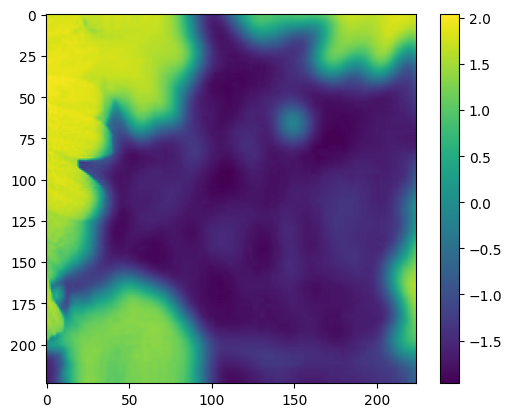

In [2]:
import matplotlib.pyplot as plt

batch_size = 60

# 加载训练数据集
train_path = "./data/train"
dataset_train = create_dataset(train_path, batch_size = batch_size, train=True)

# 加载验证数据集
val_path = "./data/val"
dataset_val = create_dataset(val_path, batch_size = 10, train=False)

print('训练数据集数量： ',dataset_train.get_dataset_size() * batch_size)
print('测试数据集数量： ',dataset_val.get_dataset_size() * 10)

# 查看训练集的样图
data_next = dataset_train.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽： ', data_next['image'][0,...].shape)
print('一张图像的标签样式： ', data_next['label'][0]) # 一共 5 类，用 0-4 的数字表达类别。
plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [3]:
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/resnet50_224.ckpt"

dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url, "./checkpoints")

In [4]:
import mindspore.nn as nn
import mindspore as ms
from mindvision.classification.models import resnet50
from mindvision.engine.loss import CrossEntropySmooth
from mindspore import Tensor
from mindspore.train import Accuracy, Loss

# 创建模型,其中目标分类数为5，图像输入大小为(224,224)
network = resnet50(num_classes=5)

# 模型参数存入到param_dict
param_dict = ms.load_checkpoint("./checkpoints/resnet50_224.ckpt")

# 获取resnet50网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
ms.load_param_into_net(network, param_dict)

# 定义优化器
learning_rate = 0.01
decay_rate = 0.12
decay_steps = 1
global_step = Tensor(0, ms.int32)
natural_exp_decay_lr = nn.NaturalExpDecayLR(learning_rate, decay_rate, decay_steps, is_stair=False)
lr = natural_exp_decay_lr(global_step)
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
# network_opt = nn.Adam(params=network.trainable_params(), learning_rate=0.001)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=5)
# network_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义评价指标
metrics = {"Accuracy": Accuracy(), "Loss": Loss()}

# 初始化模型
model = ms.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:31:29.868.836 [mindspore\nn\layer\basic.py:173] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:31:30.147.568 [mindspore\train\serialization.py:1237] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:31:30.147.568 [mindspore\train\serialization.py:1242] head.dense.weight is not loaded.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:31:30.147.568 [mindspore\train\serialization.py:1242] head.dense.bias is not loaded.


Delete parameter from checkpoint:  head.dense.weight
Delete parameter from checkpoint:  head.dense.bias


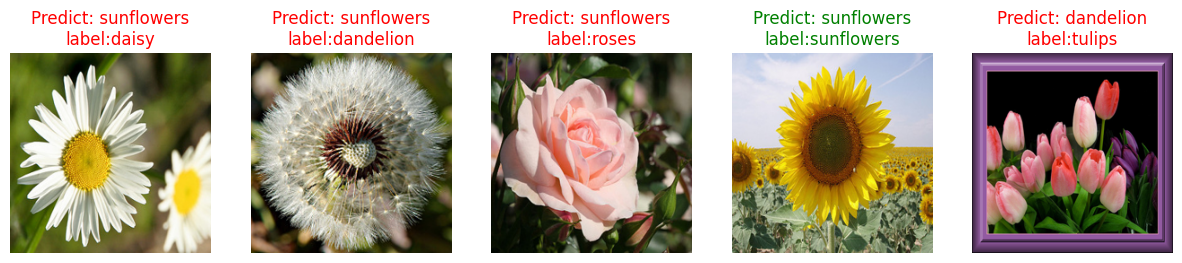

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mindvision.classification.models import resnet50
import mindspore as ms

def visualize_model(image_path, label, model=model):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    color = 'green' if class_name[result] == label else 'red'

    plt.title(f"Predict: {class_name[result]}\nlabel:{label}", color=color)
    plt.axis("off")
    return result

image1 = "./data/infer/daisy.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 5, 1)
visualize_model(image1, "daisy")

image2 = "./data/infer/dandelion.jpg"
plt.subplot(1, 5, 2)
visualize_model(image2, "dandelion")

image3 = "./data/infer/roses.jpg"
plt.subplot(1, 5, 3)
visualize_model(image3, "roses")

image4 = "./data/infer/sunflowers.jpg"
plt.subplot(1, 5, 4)
visualize_model(image4, "sunflowers")

image5 = "./data/infer/tulips.jpg"
plt.subplot(1, 5, 5)
visualize_model(image5, "tulips")

plt.show()

In [6]:
import numpy as np
from mindvision.engine.callback import ValAccMonitor
from mindspore.train import TimeMonitor, Callback

num_epochs = 3
val_interval = 1
print_interval = 1

class LossMon(Callback):
    def __init__(self, model, val_dataset, val_interval=1, print_interval=5):
        super(LossMon, self).__init__()
        self.model = model
        self.val_dataset = val_dataset
        self.val_interval = val_interval
        self.print_interval = print_interval
        self.step_count = list()
        self.train_loss = list()
        self.val_loss = list()
        self.val_acc = list()

    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()
        epoch_num = cb_params.cur_epoch_num
        step_num = cb_params.cur_step_num
        step_loss = cb_params.net_outputs
        if step_num % self.val_interval == 0:
            self.step_count.append(step_num)
            self.train_loss.append(float(step_loss))
            res = self.model.eval(self.val_dataset)
            self.val_loss.append(res["Loss"])
            self.val_acc.append(res["Accuracy"])
        if step_num % self.print_interval == 0:
            print(f"epoch: {epoch_num} step: {step_num}, loss is {step_loss}")

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
acc_mon = ValAccMonitor(model, dataset_val, num_epochs, ckpt_directory="./checkpoints")
loss_mon = LossMon(model, dataset_val, val_interval=val_interval, print_interval=print_interval)
time_mon = TimeMonitor()
model.train(num_epochs,
            dataset_train,
            callbacks=[acc_mon, loss_mon, time_mon])

[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:31:31.194.808 [mindspore\train\model.py:1099] For ValAccMonitor callback, {'end', 'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 1, loss is 1.6962665
epoch: 1 step: 2, loss is 1.5483333
epoch: 1 step: 3, loss is 1.649362
epoch: 1 step: 4, loss is 1.4116168
epoch: 1 step: 5, loss is 1.2726676
epoch: 1 step: 6, loss is 1.2270901
epoch: 1 step: 7, loss is 1.040226
epoch: 1 step: 8, loss is 0.8155129
epoch: 1 step: 9, loss is 0.81720704
epoch: 1 step: 10, loss is 0.8589291
epoch: 1 step: 11, loss is 0.74639744
epoch: 1 step: 12, loss is 0.60781467
epoch: 1 step: 13, loss is 0.70439774
epoch: 1 step: 14, loss is 0.64187217
epoch: 1 step: 15, loss is 0.7921902
epoch: 1 step: 16, loss is 0.6559771
epoch: 1 step: 17, loss is 0.6474559
epoch: 1 step: 18, loss is 0.7159641
epoch: 1 step: 19, loss is 0.7319645
epoch: 1 step: 20, loss is 0.68367976
--------------------
Epoch: [  1 /   3], Train Loss: [0.684], Accuracy:  0.980
Train epoch time: 408338.534 ms, per step time: 20416.927 ms
epoch: 2 step: 21, loss is 0.6071352
epoch: 2 step: 22, loss is 0.6672066
epoch: 2 step: 23, loss is 0.58877623
epoch: 2 step

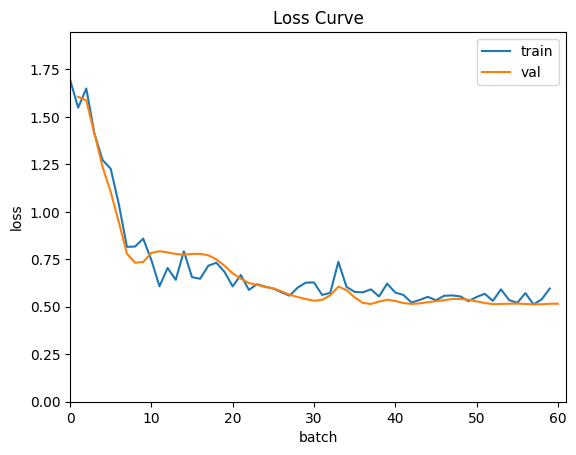

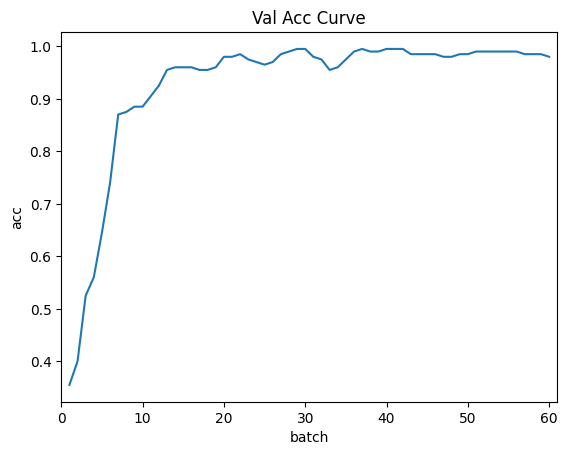

In [7]:
import matplotlib.pyplot as plt

plt.title("Loss Curve")
plt.xlabel("batch")
plt.ylabel("loss")
plt.xlim(0,loss_mon.step_count[-1]+loss_mon.step_count[0])
plt.ylim(0,max(loss_mon.train_loss+loss_mon.val_loss)+0.25)
plt.plot([i-1 for i in loss_mon.step_count],loss_mon.train_loss,label="train")  # 训练集loss和测试集loss非同时测量
plt.plot(loss_mon.step_count,loss_mon.val_loss,label="val")
plt.legend()
plt.show()

plt.title("Val Acc Curve")
plt.xlabel("batch")
plt.ylabel("acc")
plt.xlim(0,loss_mon.step_count[-1]+loss_mon.step_count[0])
plt.plot(loss_mon.step_count,loss_mon.val_acc)
plt.show()

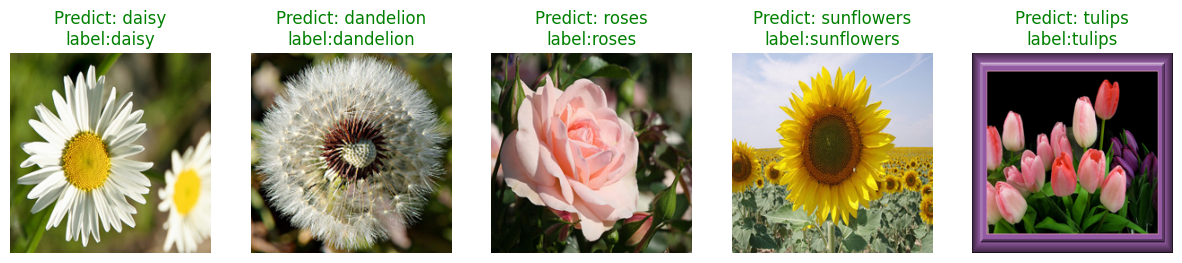

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mindvision.classification.models import resnet50
import mindspore as ms

def visualize_model(image_path, label):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = network
    param_dict = ms.load_checkpoint("./checkpoints/best.ckpt")
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    color = 'green' if class_name[result] == label else 'red'

    plt.title(f"Predict: {class_name[result]}\nlabel:{label}", color=color)
    plt.axis("off")
    return result

image1 = "./data/infer/daisy.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 5, 1)
visualize_model(image1, "daisy")

image2 = "./data/infer/dandelion.jpg"
plt.subplot(1, 5, 2)
visualize_model(image2, "dandelion")

image3 = "./data/infer/roses.jpg"
plt.subplot(1, 5, 3)
visualize_model(image3, "roses")

image4 = "./data/infer/sunflowers.jpg"
plt.subplot(1, 5, 4)
visualize_model(image4, "sunflowers")

image5 = "./data/infer/tulips.jpg"
plt.subplot(1, 5, 5)
visualize_model(image5, "tulips")

plt.show()

In [9]:
import mindspore as ms
import numpy as np

# 定义并加载网络参数
net = resnet50(num_classes=5)
param_dict = ms.load_checkpoint("./checkpoints/best.ckpt")
ms.load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
ms.export(net, ms.Tensor(input_np), file_name="./deployment/resnet50", file_format="MINDIR")

[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:49:52.781.603 [mindspore\nn\layer\basic.py:173] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:49:53.484.696 [mindspore\nn\layer\basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:49:53.547.594 [mindspore\nn\layer\basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(21852:41956,MainProcess):2023-11-18-19:49:53.594.469 [mindspore\nn\layer\basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
